# PiADM Projekt
## 1. Preprocessing danych

Dane zostają zaczytane z folderu i utworzony zostaje DataFrame zawierający filepath oraz label.

In [15]:
import os
import pandas as pd
import matplotlib.image as mpimg
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

path = "Dataset"
files = os.listdir(path)

generateImages = True
numberOfGeneratedImages = 50

def remove_augmented_images(path):
    for filename in os.listdir(path):
        if "aug" in filename:
            file_path = os.path.join(path, filename)
            os.remove(file_path)

def multiplicateData(n: int):
    data_multiplication = transforms.Compose([
        transforms.RandomRotation(degrees=30),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomResizedCrop(size=240, scale=(0.8, 1.0))
        ])
    for file in files:
        file_name, file_extension = os.path.splitext(file)
        if "aug" in file_name:
            continue
        image_path = os.path.join(path, file)
        image = Image.open(image_path)
        for j in range(n):
            multiplicated_img = data_multiplication(image)
            new_file_name = f"{file_name}_aug{j+1}{file_extension}"
            new_image_path = os.path.join(path, new_file_name)
            multiplicated_img.save(new_image_path)

if(generateImages):
    if(numberOfGeneratedImages < 1000):
        multiplicateData(numberOfGeneratedImages)

In [14]:
deleteGeneratedFiles = False
if(deleteGeneratedFiles):
    remove_augmented_images(path)

In [16]:
files = os.listdir(path)

img_table = []
labels = []
for image in files:
    image_path = os.path.join(path, image)
    img_table.append(image_path)
    base_img_name = os.path.splitext(image)[0]
    label = base_img_name.split('_')[0]
    labels.append(int(label))

img_d = zip(img_table, labels)

df_img = pd.DataFrame(data = img_d, columns=['filepath', 'label'])
print(df_img)

                 filepath  label
0           Dataset\1.jpg      1
1          Dataset\10.jpg     10
2     Dataset\10_aug1.jpg     10
3    Dataset\10_aug10.jpg     10
4    Dataset\10_aug11.jpg     10
..                    ...    ...
709   Dataset\9_aug50.jpg      9
710    Dataset\9_aug6.jpg      9
711    Dataset\9_aug7.jpg      9
712    Dataset\9_aug8.jpg      9
713    Dataset\9_aug9.jpg      9

[714 rows x 2 columns]


Przgotowanie danych do uczenia przez model. W tym celu zdjęcia ujednolicono i sprowadzono do tensora. Następnie dane zostały podzielone na zbiór testowy i treningowy.

In [17]:
class StructureDataset(Dataset):
    def __init__(self, df : pd.DataFrame, transform=None):
        self.df = df  
        self.transform = transform   


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'filepath']
        target = self.df.loc[idx, 'label']
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, target
    
def showImg(idx):
    show_img = transforms.ToPILImage()
    show_img(structure_imgs[idx][0]).show()

transform = transforms.Compose([transforms.Resize(size = (240,240)), transforms.ToTensor()])

structure_imgs = StructureDataset(df_img, transform)

num_items = len(structure_imgs)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, test_ds = random_split(structure_imgs, [num_train, num_val])

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

n_classes = df_img['label'].max() + 1

class TextureNet(nn.Module):
    def __init__(self, n_classes=n_classes):
        super(TextureNet, self).__init__()
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.feature_extractor = self._getResnet()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.nonlinear(x)
        x = self.fc1(x)
        x = self.nonlinear(x)
        scores = self.fc2(x)
        return scores

    def _getResnet(self):
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad= False
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 256)
        return model


TextureModel = TextureNet(n_classes=n_classes)
x = torch.randn(1, 3, 240, 240)
output = TextureModel(x)


In [28]:
from torchinfo import summary

summary(TextureModel, input_size=(1, 3, 240, 240))

Layer (type:depth-idx)                        Output Shape              Param #
TextureNet                                    [1, 15]                   --
├─ResNet: 1-1                                 [1, 256]                  --
│    └─Conv2d: 2-1                            [1, 64, 120, 120]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 120, 120]         (128)
│    └─ReLU: 2-3                              [1, 64, 120, 120]         --
│    └─MaxPool2d: 2-4                         [1, 64, 60, 60]           --
│    └─Sequential: 2-5                        [1, 64, 60, 60]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 60, 60]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 60, 60]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 30, 30]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 30, 30]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 30, 30]      

In [20]:
def train_epoch(train_loader, optimizer, model, loss_fn):
    running_loss = 0.
    train_loss = 0.
    num_batches = len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, labels)
        loss.backward() 
        optimizer.step() 
        running_loss += loss.item()
        train_loss += loss
    train_loss = train_loss / num_batches
    return train_loss 

def test_epoch(test_loader, model, loss_fn):
    test_loss = 0
    correct = 0
    size = len(test_loader.dataset) 
    num_batches = len(test_loader)  
    with torch.no_grad():
        for images, labels in test_loader:
            preds = model(images)
            test_loss += loss_fn(preds, labels).item()
            correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
    test_loss = test_loss / num_batches
    correct = correct / size
    return correct, test_loss

def train_model(epoch, model, train_loader, test_loader, optimizer, loss_fn):
    train_loss_tab = []
    test_loss_tab = []
    accuracy_tab = []
    for i in range(epoch):
        train_loss = train_epoch(train_loader, optimizer, model, loss_fn)
        accuracy, test_loss = test_epoch(test_loader, model, loss_fn)

        train_loss_tab.append(train_loss)
        test_loss_tab.append(test_loss)
        accuracy_tab.append(accuracy)
        print(f"EPOCH {i+ 1}  TRAIN LOSS: {train_loss}  TEST LOSS: {test_loss}  ACCURACY: {accuracy}")
    return train_loss_tab, test_loss_tab, accuracy_tab

In [21]:
import torch.optim.lr_scheduler
import torch.optim

TextureModel = TextureNet(n_classes=n_classes)

criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(TextureModel.parameters(), lr=0.001, momentum=0.9)
n_epochs = 15

In [22]:
train_tab, test_tab, acc_tab = train_model(epoch=n_epochs,
                                           model=TextureModel,
                                           train_loader=train_dl,
                                           test_loader=test_dl,
                                           optimizer=optimizer_ft,
                                           loss_fn=criterion)

EPOCH 1  TRAIN LOSS: 2.689413547515869  TEST LOSS: 2.6477251052856445  ACCURACY: 0.16783216783216784
EPOCH 2  TRAIN LOSS: 2.628593921661377  TEST LOSS: 2.5918811321258546  ACCURACY: 0.3006993006993007
EPOCH 3  TRAIN LOSS: 2.557734251022339  TEST LOSS: 2.5300902366638183  ACCURACY: 0.46853146853146854
EPOCH 4  TRAIN LOSS: 2.479959726333618  TEST LOSS: 2.4558525562286375  ACCURACY: 0.5804195804195804
EPOCH 5  TRAIN LOSS: 2.3754398822784424  TEST LOSS: 2.372858238220215  ACCURACY: 0.6573426573426573
EPOCH 6  TRAIN LOSS: 2.2684438228607178  TEST LOSS: 2.2659446716308596  ACCURACY: 0.7762237762237763
EPOCH 7  TRAIN LOSS: 2.126499891281128  TEST LOSS: 2.149437189102173  ACCURACY: 0.8041958041958042
EPOCH 8  TRAIN LOSS: 1.9782545566558838  TEST LOSS: 2.0018802165985106  ACCURACY: 0.8041958041958042
EPOCH 9  TRAIN LOSS: 1.7941265106201172  TEST LOSS: 1.8249957084655761  ACCURACY: 0.8391608391608392
EPOCH 10  TRAIN LOSS: 1.6055071353912354  TEST LOSS: 1.6567693948745728  ACCURACY: 0.86713286713

In [23]:
train_plot_loss = np.zeros(n_epochs)
for i, element  in enumerate(train_tab):
    train_plot_loss[i] = element.detach().numpy()

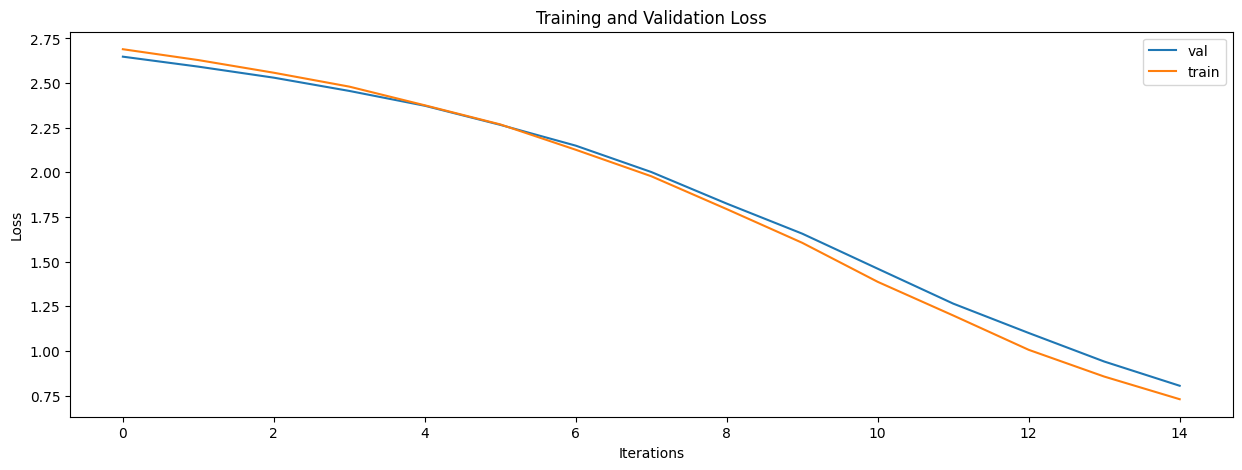

In [24]:
plt.figure(figsize=(n_epochs,5))
plt.title("Training and Validation Loss")
plt.plot(test_tab,label="val")
plt.plot(train_plot_loss,label="train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Training and Validation Loss")
plt.show()

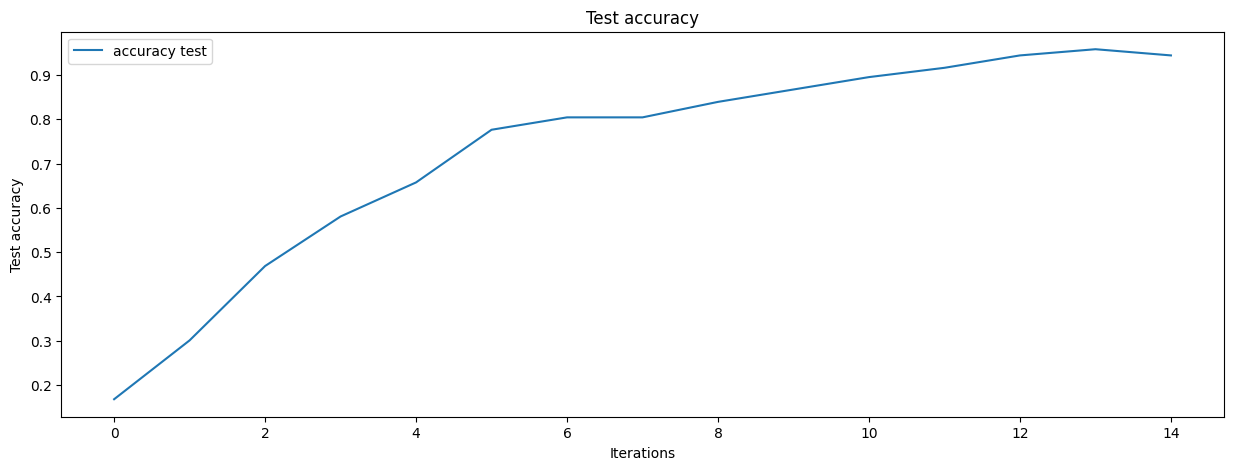

In [25]:
plt.figure(figsize=(n_epochs,5))
plt.title("Test accuracy")
plt.plot(acc_tab,label="accuracy test")
plt.xlabel("Iterations")
plt.ylabel("Test accuracy")
plt.legend()
plt.show()